# Hybrid Model - LightFM

In [93]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../')

from pathlib import Path
from typing import Set

import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

from src.models.hybrid import HybridRecommenderSystem
from src.util.data import get_interactions, get_train_test_ratings
from src.util.metrics import get_jaccard_ranking, get_classification_ranking_metrics, get_r2_score
from src.util.plot import Plot

plot = Plot()

RATINGS_PATH = Path('../data/ratings_small.csv')
MOVIES_PATH = Path('../data/movies_metadata.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [94]:
ratings = pd.read_csv(RATINGS_PATH)

In [95]:
user_encoder = LabelEncoder()
user_encoder.fit(ratings['userId'].values)

movie_encoder = LabelEncoder()
movie_encoder.fit(ratings['movieId'].values)

LabelEncoder()

In [96]:
train_ratings, test_ratings = get_train_test_ratings(ratings)

In [97]:
train_interactions = get_interactions(
    train_ratings,
    user_encoder,
    movie_encoder
)

train_interactions /= 5

train_interactions = coo_matrix(train_interactions)

Building interaction matrix: 100%|██████████| 90309/90309 [00:00<00:00, 1881433.69it/s]


In [98]:
test_interactions = get_interactions(
    test_ratings,
    user_encoder,
    movie_encoder
)

test_interactions = coo_matrix(test_interactions)

Building interaction matrix: 100%|██████████| 9695/9695 [00:00<00:00, 1212071.22it/s]


In [99]:
def get_movies_features(
    movie_encoder: LabelEncoder,
    movies_to_keep: Set[int]
):
    movies = pd.read_csv(MOVIES_PATH)
    to_drop = ["1997-08-20", "2012-09-29", "2014-01-01"]
    for drop_error in to_drop:
        movies = movies[movies.id != drop_error]

    movies.id = movies.id.astype('int64')
    movies = movies.loc[movies['id'].isin(movies_to_keep)]
    movies.id = movie_encoder.transform(movies.id)
    movies_to_keep = movie_encoder.transform(list(movies_to_keep))

    movies = movies.drop_duplicates(subset=['id'], keep='first')

    budget_Scaler = StandardScaler().fit(movies.budget.to_numpy().reshape(-1, 1))

    lang_encoder = LabelEncoder().fit(movies.original_language)

    genres_encoder = LabelEncoder().fit(movies.genres)

    spoken_languages_encoder = LabelEncoder().fit(movies.spoken_languages)

    adult_encoder = LabelEncoder().fit(movies.adult)

    belongs_to_collection_encoder = LabelEncoder().fit(
        movies.belongs_to_collection
    )

    movies.belongs_to_collection = belongs_to_collection_encoder.transform(
        movies.belongs_to_collection
    )
    movies.original_language = lang_encoder.transform(
        movies.original_language
    )
    movies.adult = adult_encoder.transform(movies.adult)
    movies.spoken_languages = spoken_languages_encoder.transform(
        movies.spoken_languages
    )
    movies.genres = genres_encoder.transform(movies.genres)
    movies.budget = budget_Scaler.transform(
        movies.budget.to_numpy().reshape(-1, 1)
    )
    movies.popularity = movies.popularity.astype("float64")

    movies = movies.drop(["homepage", "imdb_id", "original_title",
                          "overview", "poster_path",
                          "production_companies", "production_countries",
                          "release_date", "status", "tagline",
                          "title", "video"], axis=1)
    movies = movies.set_index("id")
    movies = movies.dropna()

    not_included_ids = [idx for idx in movies_to_keep
                        if idx not in movies.index]
    missing_movies = [[0] * movies.shape[1]] * len(not_included_ids)
    missing_movies = pd.DataFrame(
        data=missing_movies,
        columns=movies.columns,
        index=not_included_ids
    )
    movies = pd.concat([movies, missing_movies])
    movies = movies.sort_index()
    return movies

In [100]:
movie_features = get_movies_features(
    movie_encoder,
    movies_to_keep=set(ratings["movieId"].values)
)
movie_features = csr_matrix(movie_features.values)

## Model

In [101]:
model = HybridRecommenderSystem(user_encoder, movie_encoder)

model.fit(
    train_interactions,
    movie_features,
    no_components=20,
    epochs=1000,
    num_threads=4
)

## Tests

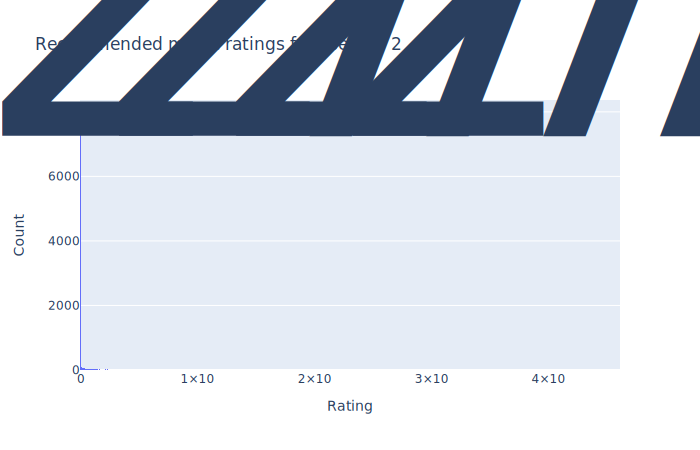

In [102]:
_, scores = model.predict_scores(2)
plot.histogram(
    x=scores,
    title=f'Recommended movie ratings for user_id: {2}',
    xaxis_title='Rating',
    yaxis_title='Count'
)

Testing predictions: 100%|██████████| 656/656 [00:06<00:00, 101.83it/s]


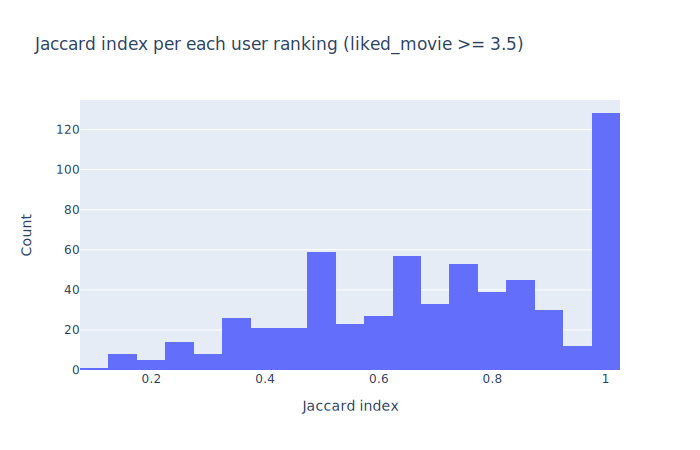

In [103]:
jaccard_ranking = get_jaccard_ranking(model, test_ratings)
plot.histogram(
    x=jaccard_ranking,
    title='Jaccard index per each user ranking (liked_movie >= 3.5)',
    xaxis_title='Jaccard index',
    yaxis_title='Count'
)

Testing predictions: 100%|██████████| 656/656 [00:06<00:00, 100.49it/s]


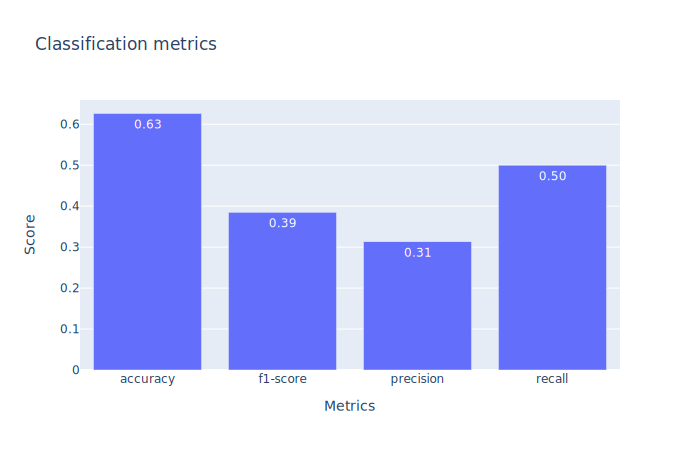

In [104]:
classification_metrics = get_classification_ranking_metrics(model, test_ratings)
plot.bar(
    classification_metrics,
    title='Classification metrics',
    xaxis_title='Metrics',
    yaxis_title='Score'
)

In [105]:
r2_score = get_r2_score(model, test_ratings)
print(f'\n\nr2 score: {r2_score:.3f}')

Testing predictions: 100%|██████████| 656/656 [00:06<00:00, 105.03it/s]

r2 score: -771477419526513332699577351923638537016249564698064991103941176417320960.000

